## 第 11 回　遺伝子データ解析

### 参考文献：先進ゲノム解析研究推進プラットフォーム (編集)、独習 Python バイオ情報解析、羊土社
---
---
### 目的：ヒト胚性幹細胞を胚様体とした分化過程のシングルセル RNA-Seq 解析データから論文用の図を作成する。

K.R. Moon et al., Visualizing structure and transitions in high-dimensional biological data, Nature Biotechnology, Vol. 37, 1482-1492, 2019.

---
---
## シングルセル解析 1

### テーブルデータの前処理のつづき

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gzip
import pickle

---
<span style="color: red">**課題 1：**</span> 前回の課題 5 で保存した df_mod.gz を フォルダ data に入っています。df という名前で読み込んでください。

In [30]:
# バイナリファイルからDataFrameを読み込む
with gzip.open('data/df_mod.gz', 'rb') as f:
    df = pickle.load(f)
display(df)

Days0-3                                    \
                AAACCGTGGCTACA-1 AAACGCTGTAGCGT-1 AAAGATCTGGTACT-1   
GeneID                                                               
ENSG00000279457                0                0                0   
ENSG00000228463                0                0                0   
ENSG00000237491                0                0                0   
ENSG00000225880                0                0                0   
ENSG00000230368                0                0                0   
...                          ...              ...              ...   
ENSG00000276256                0                0                0   
ENSG00000273748                0                0                0   
ENSG00000278817                0                0                0   
ENSG00000276345                0                0                0   
ENSG00000271254                0                0                0   

                                                                    \
                AAAGATCTTCCTTA-1 AAAGTTTGAGCTCA-1 AACAATACGACAAA-1   
GeneID                                                               
ENSG00000279457                0                0                0   
ENSG00000228463                1                0                0   
ENSG00000237491                0                0                0   
ENSG00000225880                0                0                0   
ENSG00000230368                0                0                0   
...                          ...              ...              ...   
ENSG00000276256                0                0                0   
ENSG00000273748                0                0                0   
ENSG00000278817                0                0                0   
ENSG00000276345                0                0                0   
ENSG00000271254                0                0                0   

                                                                    \
                AACAATACGCTTCC-1 AACCAGTGGAGGGT-1 AACGGTTGACGCTA-1   
GeneID                                                               
ENSG00000279457                0                0                0   
ENSG00000228463                0                0                0   
ENSG00000237491                0                0                0   
ENSG00000225880                0                1                0   
ENSG00000230368                0                0                0   
...                          ...              ...              ...   
ENSG00000276256                0                0                0   
ENSG00000273748                0                0                0   
ENSG00000278817                0                0                1   
ENSG00000276345                0                0                0   
ENSG00000271254                0                0                0   

                                  ...        Days24-27                   \
                AACGTTCTTGACCA-1  ... TTGCTAACTCGTTT-1 TTGGTACTCGATAC-1   
GeneID                            ...                                     
ENSG00000279457                0  ...                0                0   
ENSG00000228463                0  ...                1                1   
ENSG00000237491                0  ...                0                0   
ENSG00000225880                0  ...                0                0   
ENSG00000230368                0  ...                0                0   
...                          ...  ...              ...              ...   
ENSG00000276256                0  ...                0                0   
ENSG00000273748                0  ...                0                0   
ENSG00000278817                0  ...                0                0   
ENSG00000276345                0  ...                0                0   
ENSG00000271254                0  ...                0                0   

                               

---
---
### クオリティコントロール（細胞と遺伝子のフィルタリング）
すべての実験が理想的な条件下でなされることは稀で、実験の技術的な**エラー**や**ノイズ**の影響で、大抵はおかしな値（**異常値**）を示すデータが混じっている。異常値を含むデータの解析は難しくなるので、明らかに異常と思われるデータは事前に**フィルタリング**して取り除くことがある。しかし、何が異常かは、経験的な知識や分野の慣習によっても異なる。

すでに、どの細胞でもまったく発現していない（発現量の値がゼロ）遺伝子を除去して df_mod.gz に保存したが、以下では、さらにデータを絞り込むことにする。

---
### 低クオリティの細胞を DataFrame から除去
以下の 3 つの観点で細胞のクオリティを調べる

1. **細胞ごとに割り当てられたカウント**  
   あまりに数が少なくスカスカだと、それらが細胞のトランスクリプトームの全体像を反映しているとは信じられない。  
   ※トランスクリプトーム：細胞内の全DNAの塩基配列情報をさす「ゲノム」に対し、細胞内の全転写産物（全RNA）を「トランスクリプトーム」とよぶ。

2. **細胞ごとに検出された遺伝子の数**  
   あまりにも数が多すぎるのも怪しい。外れ値的に検出遺伝子数が多いバーコードは疑わしいことが確かなので、安全のために取り除く。

3. **ミトコンドリア遺伝子の発現量**  
   全体の遺伝子発現のうち、ミトコンドリア遺伝子の発現がどの程度を占めるのかは細胞ごとにある程度安定している。しかし死細胞などクオリティの低い細胞の場合、この値が異常に大きくなることがある。

---
### 1. について
縦方向に足し算をすることで細胞ごとのカウント、検出遺伝子の数を計算できる。

In [31]:
# axis=0 で縦方向の総和を計算する。つまり細胞ごとに割り当てられたカウント。
counts = df.values.sum(axis=0)

# counts は細胞の数だけ要素を持つリストなので，
# 最大値（max），最小値（min），平均値（average）を出力してみる
print('Stats for counts:',
      'max=', np.max(counts),
      'min=', np.min(counts),
      f'average= {np.average(counts):.2f}')

Stats for counts: max= 28927 min= 940 average= 4637.68


---
### 2. について
発現量ではなく発現の有無を縦方向に足し算をすることで、細胞ごとに検出された遺伝子の数を計算できる。

In [32]:
# 細胞ごとにわずかにでも検出された遺伝子の数を計算する。
# > 0.0 の部分で、DataFrame の各要素についてゼロか、それ以上かの論理値 {True, False} になる
# astype(int) とすると {True, False} が {1, 0} に変換される
# その総和をとることで「ゼロではなかった要素の数」が計算できる
n_genes = (df.values > 0.0).astype(int).sum(axis=0)

# counts, n_genesはどちらも細胞の数だけ要素を持つリストなので，
# 最大値（max），最小値（min），平均値（average）を出力してみる
print('Stats for detected genes:',
      'max=', np.max(n_genes),
      'min=', np.min(n_genes),
      f'average= {np.average(n_genes):.2f}')

Stats for detected genes: max= 4656 min= 237 average= 1568.44


---
### 3. について
遺伝子のシンボルが「MT-」から始まるミトコンドリア遺伝子についてのカウントの和を細胞ごとの総カウントと比較して、全体のうちのパーセンテージを計算する。

In [33]:
# genes.tsv の読込み
# pandas の read_csv() 関数でタブ区切り（sep='\t'）のテキストを読込む
genes = pd.read_csv(
    'data/genes.tsv',
    sep='\t',
    index_col=0,
    names=['GeneID', 'Symbol'])

# 上で読み込んだ genes は遺伝子 ID と遺伝子のシンボルが記述された DataFrame。
# 遺伝子名が「MT-」から始まる（startswith()関数）遺伝子 ID を表示してみる。
# Python 標準の文字列処理関数のいくつかは、Pandas の str アクセサで series 全体に適用できる
display(genes.loc[genes['Symbol'].str.startswith('MT-'), :])
mito_genes_index = genes.index[genes['Symbol'].str.startswith('MT-')]

# 細胞ごとに mito_genes_indexの数値の割合（%）を計算
percent_mito = 100.0 * df.loc[mito_genes_index, :].values.sum(axis=0) / df.values.sum(axis=0)
#percent_mito
#len(percent_mito)

,Symbol
GeneID,
ENSG00000198888,MT-ND1
ENSG00000198763,MT-ND2
ENSG00000198804,MT-CO1
ENSG00000198712,MT-CO2
ENSG00000228253,MT-ATP8
ENSG00000198899,MT-ATP6
ENSG00000198938,MT-CO3
ENSG00000198840,MT-ND3
ENSG00000212907,MT-ND4L


---
### 1, 2, 3 の数値データのバイオリンプロット
<span style="color: red">**課題 2：**</span> 1、2、3 の数値データ counts、n_genes、percent_mito をバイオリンプロットで可視化して下さい。

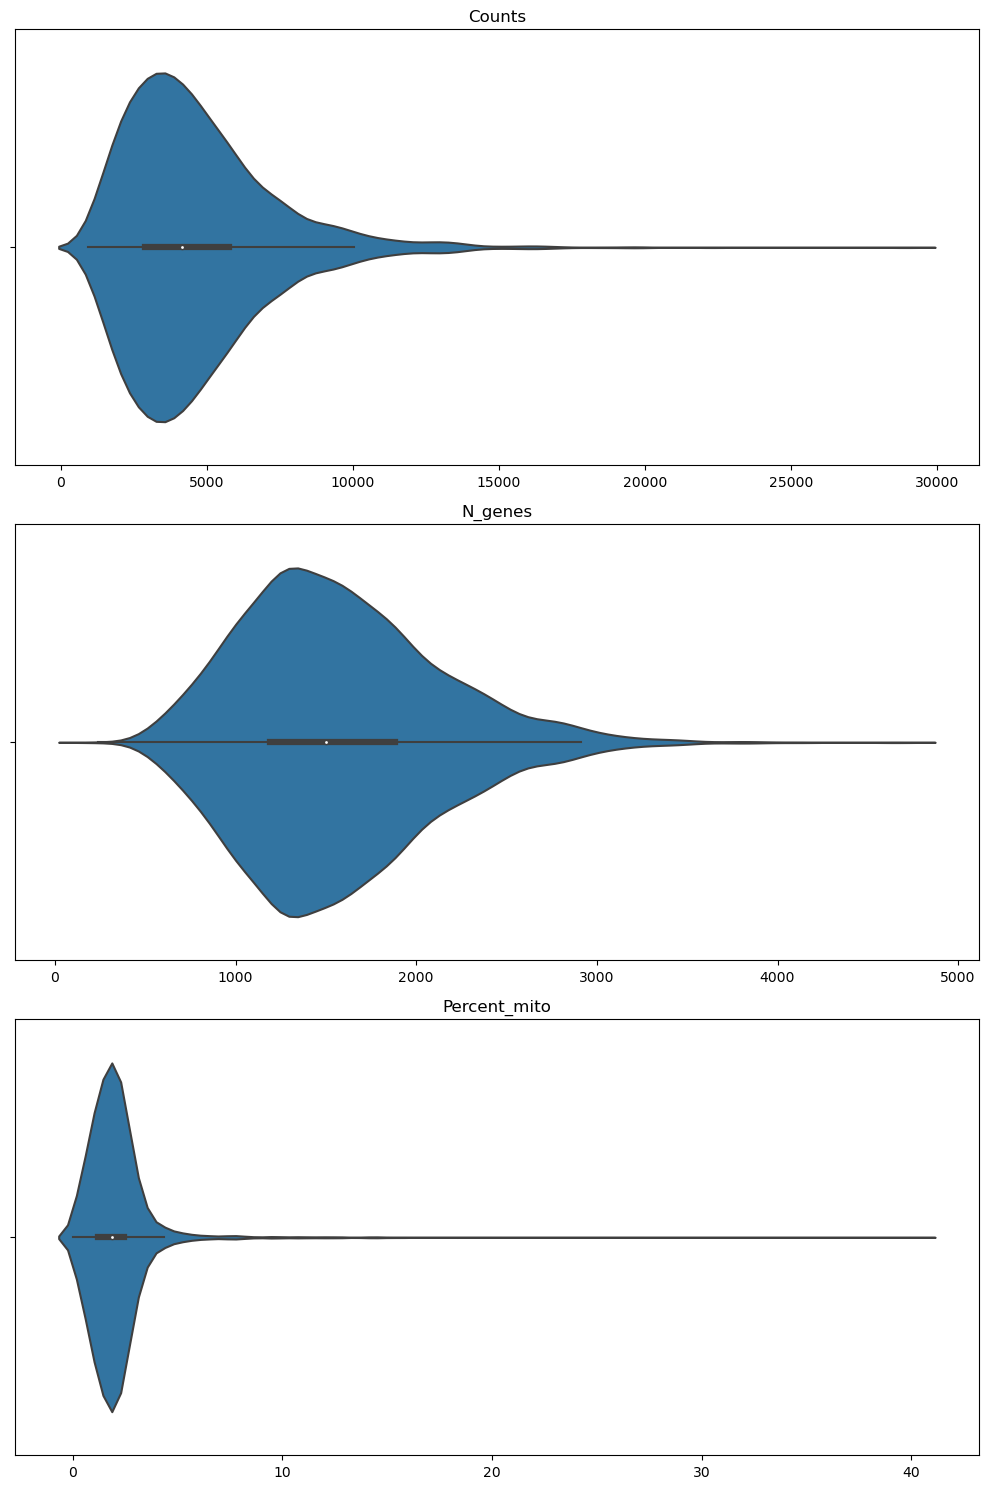

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# countsのバイオリンプロット
sns.violinplot(x=counts, ax=axs[0])
axs[0].set_title('Counts')

# n_genesのバイオリンプロット
sns.violinplot(x=n_genes, ax=axs[1])
axs[1].set_title('N_genes')

# percent_mitoのバイオリンプロット
sns.violinplot(x=percent_mito, ax=axs[2])
axs[2].set_title('Percent_mito')

# プロットの表示
plt.tight_layout()
plt.show()


---
#### 散布図（counts と percent_mito の組み合わせ、counts と n_gene の組み合わせ）

<span style="color: red">**課題 3：**</span> counts と percent_mito の散布図と counts と n_gene の散布図を横に並べて描いて下さい。ただし、ただし、counts と percent_mito の散布図では、縦軸の %mitochondorial genes expressions の値が 15 の所に水平な参照線を描くこと。また、ounts と n_gene の散布図では、縦軸の number of genes の値が 500 と 4000 の所に水平な参照線を描くこと。

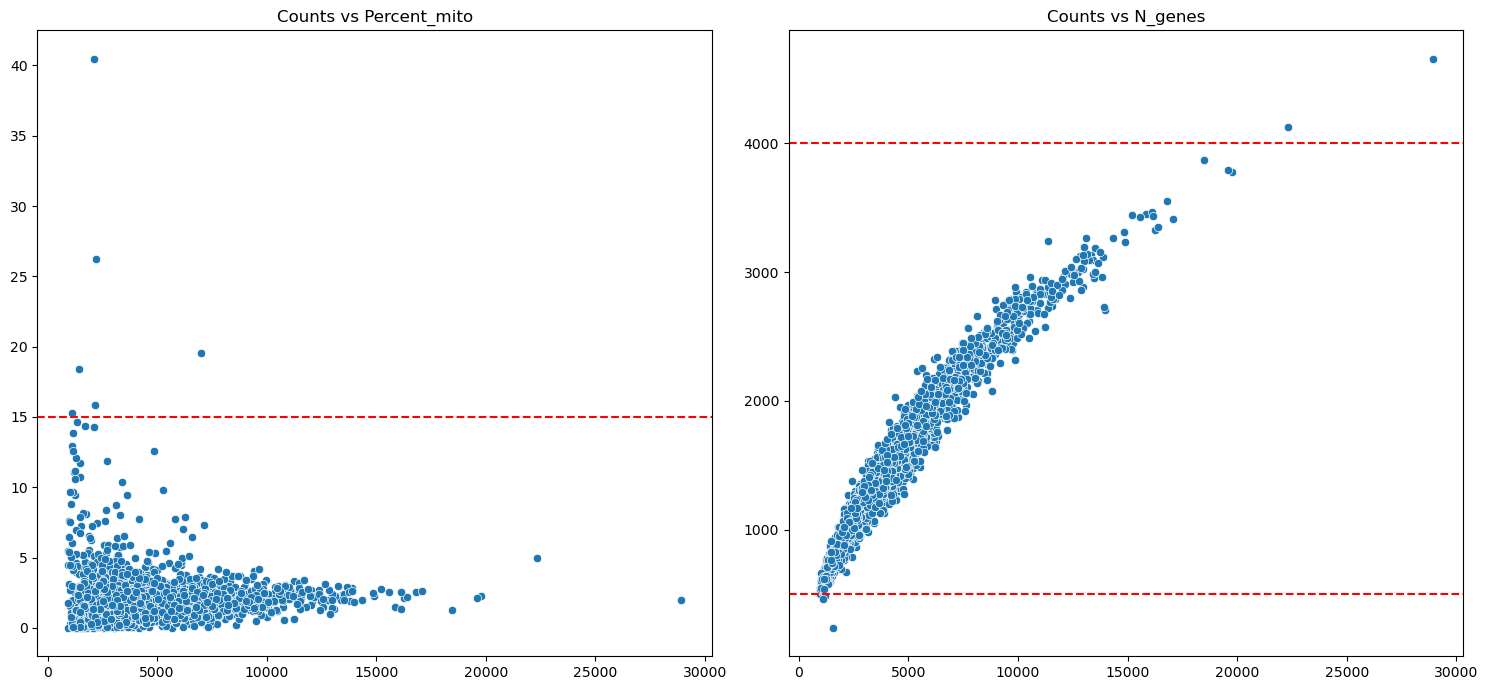

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# countsとpercent_mitoの散布図
sns.scatterplot(x=counts, y=percent_mito, ax=axs[0])
axs[0].set_title('Counts vs Percent_mito')
axs[0].axhline(y=15, color='r', linestyle='--')  # 参照線を描く

# countsとn_genesの散布図
sns.scatterplot(x=counts, y=n_genes, ax=axs[1])
axs[1].set_title('Counts vs N_genes')
axs[1].axhline(y=500, color='r', linestyle='--')  # 参照線を描く
axs[1].axhline(y=4000, color='r', linestyle='--')  # 参照線を描く

# プロットの表示
plt.tight_layout()
plt.show()


左の図から、ミトコンドリア遺伝子の発現割合が大きい細胞は、割り当てられたカウントが少ない傾向にあることがわかる。この傾向をもとに、低クオリティの細胞をフィルタリングするための値を判断する。ここでは

- 検出遺伝子数が 501 以上 4000 未満
- ミトコンドリア遺伝子の発現割合が 15% 未満

であるような細胞を解析の対象とする。

<span style="color: red">**課題 4：**</span> 上の条件を満たす細胞のみを抽出して、df_filtered という名前の DataFrame を作って下さい。

In [37]:
filtered_cells = df.columns[(n_genes > 500) & (n_genes < 4000) & (percent_mito < 15)]

df_filtered = df.loc[:,filtered_cells]
# # 条件に基づいてデータをフィルタリング

# dataframe = pd.DataFrame(zip(counts,n_genes,percent_mito),columns=["counts","n_genes","percent_mito"])
# # 条件に基づいてデータをフィルタリング
# df_filtered = dataframe[(dataframe['n_genes'] >= 501) & (dataframe['n_genes'] < 4000) & (dataframe['percent_mito'] < 15)]
display(df_filtered)

Days0-3                                    \
                AAACCGTGGCTACA-1 AAACGCTGTAGCGT-1 AAAGATCTGGTACT-1   
GeneID                                                               
ENSG00000279457                0                0                0   
ENSG00000228463                0                0                0   
ENSG00000237491                0                0                0   
ENSG00000225880                0                0                0   
ENSG00000230368                0                0                0   
...                          ...              ...              ...   
ENSG00000276256                0                0                0   
ENSG00000273748                0                0                0   
ENSG00000278817                0                0                0   
ENSG00000276345                0                0                0   
ENSG00000271254                0                0                0   

                                                                    \
                AAAGATCTTCCTTA-1 AAAGTTTGAGCTCA-1 AACAATACGACAAA-1   
GeneID                                                               
ENSG00000279457                0                0                0   
ENSG00000228463                1                0                0   
ENSG00000237491                0                0                0   
ENSG00000225880                0                0                0   
ENSG00000230368                0                0                0   
...                          ...              ...              ...   
ENSG00000276256                0                0                0   
ENSG00000273748                0                0                0   
ENSG00000278817                0                0                0   
ENSG00000276345                0                0                0   
ENSG00000271254                0                0                0   

                                                                    \
                AACAATACGCTTCC-1 AACGGTTGACGCTA-1 AACGTTCTTGACCA-1   
GeneID                                                               
ENSG00000279457                0                0                0   
ENSG00000228463                0                0                0   
ENSG00000237491                0                0                0   
ENSG00000225880                0                0                0   
ENSG00000230368                0                0                0   
...                          ...              ...              ...   
ENSG00000276256                0                0                0   
ENSG00000273748                0                0                0   
ENSG00000278817                0                1                0   
ENSG00000276345                0                0                0   
ENSG00000271254                0                0                0   

                                  ...        Days24-27                   \
                AACTACCTTTACTC-1  ... TTGCTAACTCGTTT-1 TTGGTACTCGATAC-1   
GeneID                            ...                                     
ENSG00000279457                0  ...                0                0   
ENSG00000228463                0  ...                1                1   
ENSG00000237491                0  ...                0                0   
ENSG00000225880                0  ...                0                0   
ENSG00000230368                0  ...                0                0   
...                          ...  ...              ...              ...   
ENSG00000276256                0  ...                0                0   
ENSG00000273748                0  ...                0                0   
ENSG00000278817                0  ...                0                0   
ENSG00000276345                0  ...                0                0   
ENSG00000271254                0  ...                0                0   

                               

結果、3102 個の細胞が解析対象として残った。

---
### データの正規化と対数変換

細胞ごとに割り当てられているカウントは異なるので、それぞれの細胞の遺伝子発現量の値を直接比較することはできない。そのため何らかの手法でデータに**正規化**（normalization）の処理をして、比較可能な値に変換する必要がある。ここでは、単純にシークエンスカウンタの割合を計算して、さらに値が小さくなりすぎないように全体に 10,000 をかけて正規化することにする。

In [38]:
# 単純な万分率で正規化

normalized = 10000 * df_filtered.values / df_filtered.values.sum(axis=0)

遺伝子発現量のような生物学のデータに限らず、さまざまなデータは裾が太い（fat tail）分布になることがある。このようなときは、対数を用いると良い。ただし、0 の対数がマイナス無限大になることを避けるために、1 を足して対数をとる。

In [39]:
# 全体に　1　を足して log をとる
# np.log1p(x) は np.log(1+x) と同じ意味だが、x が小さいときにより精確である

lognormalized = np.log1p(normalized)

df_lognormalized = pd.DataFrame(
    lognormalized,
    index = df_filtered.index,
    columns = df_filtered.columns
)

df_lognormalized

Days0-3                                    \
                AAACCGTGGCTACA-1 AAACGCTGTAGCGT-1 AAAGATCTGGTACT-1   
GeneID                                                               
ENSG00000279457              0.0              0.0              0.0   
ENSG00000228463              0.0              0.0              0.0   
ENSG00000237491              0.0              0.0              0.0   
ENSG00000225880              0.0              0.0              0.0   
ENSG00000230368              0.0              0.0              0.0   
...                          ...              ...              ...   
ENSG00000276256              0.0              0.0              0.0   
ENSG00000273748              0.0              0.0              0.0   
ENSG00000278817              0.0              0.0              0.0   
ENSG00000276345              0.0              0.0              0.0   
ENSG00000271254              0.0              0.0              0.0   

                                                                    \
                AAAGATCTTCCTTA-1 AAAGTTTGAGCTCA-1 AACAATACGACAAA-1   
GeneID                                                               
ENSG00000279457         0.000000              0.0              0.0   
ENSG00000228463         0.559562              0.0              0.0   
ENSG00000237491         0.000000              0.0              0.0   
ENSG00000225880         0.000000              0.0              0.0   
ENSG00000230368         0.000000              0.0              0.0   
...                          ...              ...              ...   
ENSG00000276256         0.000000              0.0              0.0   
ENSG00000273748         0.000000              0.0              0.0   
ENSG00000278817         0.000000              0.0              0.0   
ENSG00000276345         0.000000              0.0              0.0   
ENSG00000271254         0.000000              0.0              0.0   

                                                                    \
                AACAATACGCTTCC-1 AACGGTTGACGCTA-1 AACGTTCTTGACCA-1   
GeneID                                                               
ENSG00000279457              0.0         0.000000              0.0   
ENSG00000228463              0.0         0.000000              0.0   
ENSG00000237491              0.0         0.000000              0.0   
ENSG00000225880              0.0         0.000000              0.0   
ENSG00000230368              0.0         0.000000              0.0   
...                          ...              ...              ...   
ENSG00000276256              0.0         0.000000              0.0   
ENSG00000273748              0.0         0.000000              0.0   
ENSG00000278817              0.0         1.024161              0.0   
ENSG00000276345              0.0         0.000000              0.0   
ENSG00000271254              0.0         0.000000              0.0   

                                  ...        Days24-27                   \
                AACTACCTTTACTC-1  ... TTGCTAACTCGTTT-1 TTGGTACTCGATAC-1   
GeneID                            ...                                     
ENSG00000279457              0.0  ...         0.000000         0.000000   
ENSG00000228463              0.0  ...         1.245666         1.217487   
ENSG00000237491              0.0  ...         0.000000         0.000000   
ENSG00000225880              0.0  ...         0.000000         0.000000   
ENSG00000230368              0.0  ...         0.000000         0.000000   
...                          ...  ...              ...              ...   
ENSG00000276256              0.0  ...         0.000000         0.000000   
ENSG00000273748              0.0  ...         0.000000         0.000000   
ENSG00000278817              0.0  ...         0.000000         0.000000   
ENSG00000276345              0.0  ...         0.000000         0.000000   
ENSG00000271254              0.0  ...         0.000000         0.000000   

                               

---
### 特徴量選択（発現量変動の大きい遺伝子の抽出）
**・**細胞ごとの**発現量変動**の大きい遺伝子を、発現量変動の大きい順に上位から 2,000 個抽出することにする。

**・発現量変動の大きさ**を**分散平均比**（variance-to-mean ratio, VMR, index of dispersion などとも呼ばれる）で評価する。

**・分散平均値**は、遺伝子ごとの「細胞間発現量の分散」を「発現量の平均値」で割った値。この値が大きい遺伝子が「発現量変動が大きい」遺伝子と考える。

#### 発現量の平均値

In [40]:
# 対数変換したデータなので exp で戻して平均発現量を計算する
# expm1() は log1p() と逆の計算 （exp(x) - 1） で log1p() 同様小さい値でより計算精度が高い
# 平均、分散は遺伝子ごとの計算なので、計算の方向は横方向（axis=1）
mean_expressions = np.expm1(df_lognormalized.values).mean(axis=1)

# このあと平均値で割り算するときにゼロ除算エラーになったらまずいので、小さな値を設定しておく
mean_expressions[mean_expressions == 0] = 1e-12

# 遺伝子ごとの統計量を記録する新しい DataFrame を用意する
log_mean_expressions = np.log1p(mean_expressions)
genes_stats = pd.DataFrame(log_mean_expressions,
                           index=df_lognormalized.index,
                           columns=['AverageExpr'])

genes_stats

,AverageExpr
GeneID,
ENSG00000279457,0.075988
ENSG00000228463,0.252027
ENSG00000237491,0.035718
ENSG00000225880,0.012935
ENSG00000230368,0.013035
...,...
ENSG00000276256,0.064338
ENSG00000273748,0.002690
ENSG00000278817,0.101791


#### 分散平均値：発現量の分散を平均値で割る

In [41]:
# 分散を計算して、平均で割る
dispersion = np.expm1(df_lognormalized.values).var(axis=1, ddof=1) / mean_expressions
dispersion[dispersion == 0] = np.nan

# genes_stats に列を追加
dispersion = np.log(dispersion)
genes_stats['Dispersion'] = dispersion

genes_stats

,AverageExpr,Dispersion
GeneID,,
ENSG00000279457,0.075988,1.212828
ENSG00000228463,0.252027,1.320736
ENSG00000237491,0.035718,1.290866
ENSG00000225880,0.012935,1.134958
ENSG00000230368,0.013035,0.978903
...,...,...
ENSG00000276256,0.064338,1.143825
ENSG00000273748,0.002690,1.094697
ENSG00000278817,0.101791,1.232374


#### 平均値と分散平均比の関係を可視化

genes_stats の Dispersion の項目の上位 2000 個の遺伝子を取り出して、それらを赤で、それ以外を灰色でプロット。

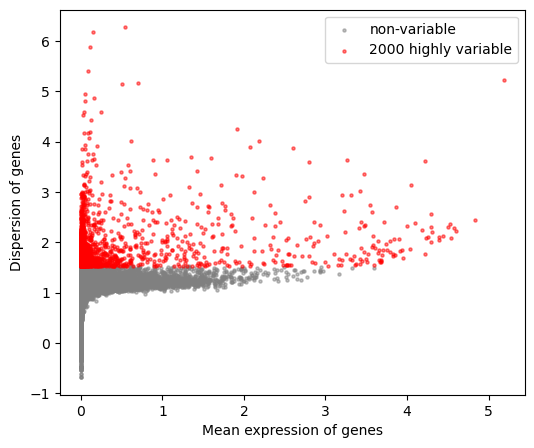

In [42]:
# 変動の大きい順に2,000個抽出することにする
n_highly_variable = 2000

# 遺伝子のDataFrameをDispersionの項目でソートする
# ascending=Falseで降順にソートされる（＝値が最大のものが最初にくる）
# その後，head関数で上から2,000個取り出せば，
# Dispersionの上位2,000個の遺伝子のインデックスが取得できる
genes_disp = genes_stats.sort_values(by=['Dispersion'], ascending=False)
highly_variable_genes = genes_disp.head(n_highly_variable).index

# HVG（Highly variable genes）であるか否かの真偽値を設定する
isHVG = genes_stats.index.isin(highly_variable_genes)

fig, ax = plt.subplots(figsize=(6,5))

# HVGではない（~isHVG）遺伝子のみを灰色でプロット
ax.scatter(
    genes_stats.loc[~isHVG, 'AverageExpr'],
    genes_stats.loc[~isHVG, 'Dispersion'],
    c = 'gray',
    s = 5,
    alpha = 0.5,
    label = 'non-variable'
)

# HVGである（isHVG）遺伝子を赤色でプロット
ax.scatter(
    genes_stats.loc[isHVG, 'AverageExpr'],
    genes_stats.loc[isHVG, 'Dispersion'],
    c = 'red',
    s = 5,
    alpha = 0.5,
    label=f'{n_highly_variable} highly variable'
)

ax.set_xlabel('Mean expression of genes')
ax.set_ylabel('Dispersion of genes')
plt.legend()
plt.show()

#### df_lognormalized から 2000 highly variable genes を抽出

In [43]:
# 正規化テーブルから、highly variable genes の項目のみ抽出

df_HVGs = df_lognormalized.loc[isHVG, :]
print(df_HVGs.shape)

(2000, 3102)


---
### データの標準化

<span style="color: red">**課題 5：**</span> df_HVGs を標準化して、新たに scaled values という名前の DataFrame を作って下さい。ただし、外れ値の影響を緩和するために、10 以上の値は 10 に設定して下さい。

In [44]:
from sklearn.preprocessing import StandardScaler

# データの標準化
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_HVGs)

# DataFrameに変換
scaled_values = pd.DataFrame(scaled_values, columns=df_HVGs.columns)

# 10以上の値は10に設定
scaled_values[scaled_values > 10] = 10
display(scaled_values)

Days0-3                                                     \
     AAACCGTGGCTACA-1 AAACGCTGTAGCGT-1 AAAGATCTGGTACT-1 AAAGATCTTCCTTA-1   
0           -0.312092        -0.363190        -0.347993        -0.362325   
1           -0.312092        -0.363190        -0.347993        -0.362325   
2           -0.312092        -0.363190        -0.347993        -0.362325   
3           -0.312092        -0.363190        -0.347993        -0.362325   
4           -0.312092        -0.363190        -0.347993        -0.362325   
...               ...              ...              ...              ...   
1995         1.479318         2.916575         2.209261         3.032732   
1996         2.546304         3.830835         3.950971         3.865417   
1997         2.135549         2.873889         3.043619         3.321304   
1998         1.479318         1.157301         0.963695         0.962477   
1999         2.546304         3.539646         3.587836         3.186253   

                                                                          \
     AAAGTTTGAGCTCA-1 AACAATACGACAAA-1 AACAATACGCTTCC-1 AACGGTTGACGCTA-1   
0           -0.358640        -0.319691        -0.337109        -0.338221   
1           -0.358640        -0.319691        -0.337109        -0.338221   
2           -0.358640        -0.319691        -0.337109        -0.338221   
3           -0.358640        -0.319691        -0.337109        -0.338221   
4           -0.358640        -0.319691        -0.337109        -0.338221   
...               ...              ...              ...              ...   
1995         3.180673        -0.319691         2.918838         4.240945   
1996         3.679211         1.375427         4.776297         4.935148   
1997         3.010902        -0.319691         4.352921         4.104299   
1998         1.662839        -0.319691         1.536527         2.552587   
1999         3.099036        -0.319691         4.107329         4.882288   

                                        ...        Days24-27                   \
     AACGTTCTTGACCA-1 AACTACCTTTACTC-1  ... TTGCTAACTCGTTT-1 TTGGTACTCGATAC-1   
0           -0.356326        -0.337018  ...        -0.364180        -0.391406   
1           -0.356326        -0.337018  ...        -0.364180        -0.391406   
2           -0.356326        -0.337018  ...        -0.364180        -0.391406   
3           -0.356326        -0.337018  ...        -0.364180         1.908408   
4           -0.356326        -0.337018  ...        -0.364180        -0.391406   
...               ...              ...  ...              ...              ...   
1995         3.257044         2.145581  ...         3.182884         1.908408   
1996         3.600501         3.890034  ...         3.182884         3.019881   
1997         3.383639         3.138628  ...         3.182884         2.758069   
1998         1.563902         0.747736  ...         1.039629        -0.391406   
1999         3.257044         3.931380  ...         3.182884         3.408136   

                                                                          \
     TTGTAGCTAGTGTC-1 TTGTAGCTTCGATG-1 TTTAGCTGCTCCAC-1 TTTCAGTGTGCTTT-1   
0           -0.346622        -0.354985        -0.362297        -0.345943   
1           -0.346622        -0.354985        -0.362297        -0.345943   
2           -0.346622        -0.354985        -0.362297        -0.345943   
3           -0.346622        -0.354985         1.258509         1.494917   
4           -0.346622        -0.354985        -0.362297        -0.345943   
...               ...              ...              ...              ...   
1995        -0.346622         1.229632         2.283170         3.105467   
1996         2.447641         2.522209         3.635344         3.300555   
1997         3.019510         2.522209         2.574050         1.494917   
1998         1.774508         1.229632         1.258509         1.494917   
1999         3.281619         2.934888         2.803778         1.4949

---
### 処理データの保存

In [45]:
# 遺伝子　ID　と名前の対応表
# このテーブルはそれほど大きくないので、そのままテキストで書き出す
# sep='\t'を指定すると、タブ区切りテキストファイルとして出力される
# genes.to_csv('data/genes.tsv', sep='\t')

# 標準化前のデータ
df_HVGs.to_pickle('data/df_HVGs.gz')

# 標準化後のデータ
scaled_values.to_pickle('data/df_scaled.gz')